In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Well in 2D ##

In class we considered the problem of a 2D well, running from $x=0$ to $x=a$, and from $y=0$ to $y=\infty$, with the sides held at zero potential and the bottom (at $y=0$) held at fixed potential $V$.

We solved this problem using separation of variables in Cartesian coordinates, obtaining a Fourier (sine) series:
$$
  \Phi(x,y) = \sum_{n=1}^\infty  A_n \sin\frac{n\pi x}{a} e^{-n\pi y/a}
$$
The boundary condition at $y=0$ gave
$$
  A_n = \frac{2V}{a}\int_0^a dx\ \sin\frac{n\pi x}{a} = \frac{4V}{n\pi}
  \quad\textrm{for odd }n\textrm{ else 0}
$$

Let us consider doing this sum numerically.

In [2]:
# First we do this by brute force, since it's actually pretty simple.
def Phi_brute_force(x,y,Nmax=10):
    """Returns the sum for Phi(x,y), up to Nmax.  Assumes V=a=1, or if
       you prefer specify x and y in units of a and get a result in units of V."""
    # Do this each time... kind of wasteful, but...
    nn = np.arange(Nmax+1)
    An = 4/np.pi/(nn+1e-10)
    An[::2] = 0.0  # Zero the even An.
    Phi = np.sum(An*np.sin(nn*np.pi*x)*np.exp(-nn*np.pi*y))
    return(Phi)

Text(0, 0.5, '$y/a$')

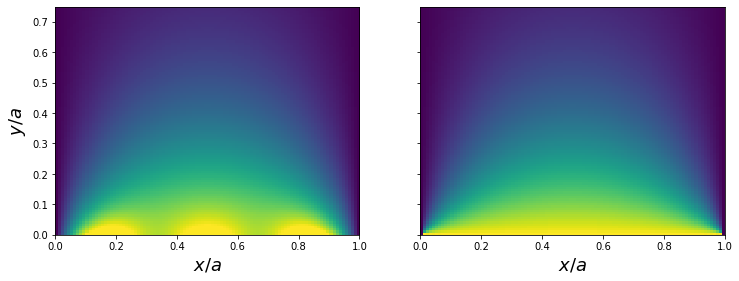

In [3]:
# Now make a figure plotting this for two values of Nmax.
# Do this with loops, to make the logic clearer even though that isn't very Pythonic.
Nx,Ny = 100,100
xx,yy = np.linspace(0,1,Nx),np.linspace(0,0.75,Ny)    
PhiL,PhiR = np.zeros( (Nx,Ny) ),np.zeros( (Nx,Ny) )
for ix in range(Nx):
    for iy in range(Ny):
        PhiL[ix,iy] = Phi_brute_force(xx[ix],yy[iy],Nmax=5)
        PhiR[ix,iy] = Phi_brute_force(xx[ix],yy[iy],Nmax=500)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(12,6))
ax[0].imshow(PhiL.T,origin='lower',extent=[xx[0],xx[-1],yy[0],yy[-1]],vmin=0,vmax=1.,aspect='equal')
ax[1].imshow(PhiR.T,origin='lower',extent=[xx[0],xx[-1],yy[0],yy[-1]],vmin=0,vmax=1.,aspect='equal')
ax[0].set_xlabel(r'$x/a$',fontsize=18)
ax[1].set_xlabel(r'$x/a$',fontsize=18)
ax[0].set_ylabel(r'$y/a$',fontsize=18)

Note the convergence of the solution is more rapid at high $y$ than at low, completely as expected.  When we have Nmax=5 only 3 terms contribute, so the approximation for low $y$ shows the oscillations from the sine sum quite clearly.  This is less true for Nmax=500.

## Convergence near y=0 ##

We can study the convergence near $y=0$ more quantitatively.  Let's choose $y=0.05\,a$ and plot $\Phi(0.25,0.05,N_{\rm max})$ vs. $N_{\rm max}$.

Text(0, 0.5, '$\\left| \\Phi_N / \\Phi_\\infty - 1\\right|$')

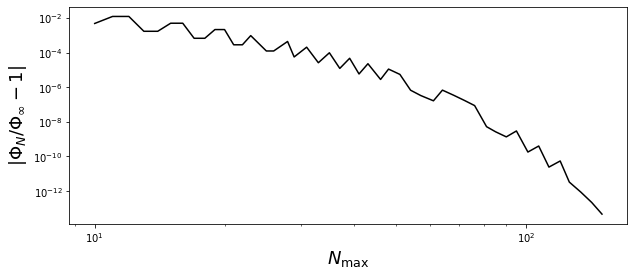

In [4]:
Nmax = np.rint(np.logspace(1.0,2.2,50)).astype('int')
PhiV = np.array([Phi_brute_force(0.25,0.05,nn) for nn in Nmax])
# Plot the fractional error, using the last value as "truth".
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(Nmax[:-1],np.abs(PhiV[:-1]/PhiV[-1]-1),'k-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N_{\rm max}$',fontsize=18)
ax.set_ylabel(r'$\left| \Phi_N / \Phi_\infty - 1\right|$',fontsize=18)

## Apodization ##

Note that we see some "ringing" structure in the figure above due to the periodicity of $\sin(n\pi x/a)$.  We could smooth this by apodizing the sum, i.e. multiplying by a window that smoothly goes to zero at the first omitted term.  Let's modify our brute force sum routine to include such a factor.  I've chosen $\cos(n\pi/2n_{\rm max})$ but many other choices are possible.

In [5]:
# Include apodization.
def Phi_apodized(x,y,Nmax=10):
    """Returns the sum for Phi(x,y), up to Nmax.  Assumes V=a=1, or if
       you prefer specify x and y in units of a and get a result in units of V."""
    # Do this each time... kind of wasteful, but...
    nn  = np.arange(Nmax+1)
    An  = 4/np.pi/(nn+1e-10)
    An[::2] = 0.0  # Zero the even An.
    ap  = np.cos( nn/(Nmax+1.) * np.pi/2.)  # For now!
    Phi = np.sum(An*np.sin(nn*np.pi*x)*np.exp(-nn*np.pi*y) * ap)
    return(Phi)

Text(0, 0.5, '$\\left| \\Phi_N / \\Phi_\\infty - 1\\right|$')

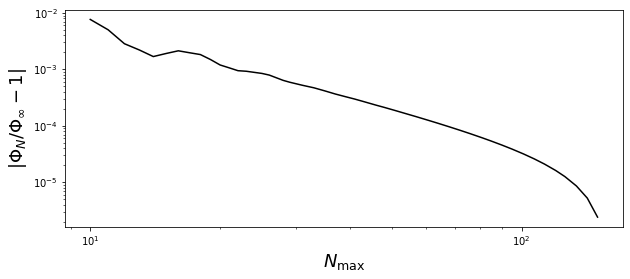

In [6]:
Nmax = np.rint(np.logspace(1.0,2.2,50)).astype('int')
PhiV = np.array([Phi_apodized(0.25,0.05,nn) for nn in Nmax])
# Plot the fractional error, using the last value as "truth".
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(Nmax[:-1],np.abs(PhiV[:-1]/PhiV[-1]-1),'k-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N_{\rm max}$',fontsize=18)
ax.set_ylabel(r'$\left| \Phi_N / \Phi_\infty - 1\right|$',fontsize=18)

## Series acceleration ##

This problem is not really complex enough to require series acceleration, but I just wanted to mention that it's the kind of thing you might want to do in a more complex setting if CPU time was at a premium but your time wasn't (or if you happened to have a handy graduate or undergraduate student who's time felt cheap to you ...).

## Modify the BC ##

Finally let's consider a modification of the boundary condition at $y=0$.  We'll choose a triangle rising linearly from $V=0$ at $x=0$ to $V=1$ at $x=a/2$ and falling linearly back to $V=0$ by $x=a$.  It's not hard to compute the $A_n$ in this case, but let's have the computer do it for us. 

In [7]:
# Compute the A_n coefficients for a triangle.  Pretend at first
# we've never heard of the Fast Fourier Transform and we don't know
# that this problem can be solved analytically!
def compute_An(Nmax):
    """Compute the A_n by brute force."""
    An = np.zeros(Nmax+1)
    x1 = np.linspace(0,0.5,500)
    x2 = np.linspace(0.5,1,500)
    for n in range(Nmax+1):
        An[n] = 2*np.trapz( np.sin(n*np.pi*x1)*2*(  x1), x=x1 )+\
                2*np.trapz( np.sin(n*np.pi*x2)*2*(1-x2), x=x2 )
    return(An)
#
def Phi_given_An(x,y,An):
    """Returns the sum for Phi(x,y), given An."""
    nn  = np.arange(An.size)
    Phi = np.sum(An*np.sin(nn*np.pi*x)*np.exp(-nn*np.pi*y))
    return(Phi)

Text(0, 0.5, '$A_n$')

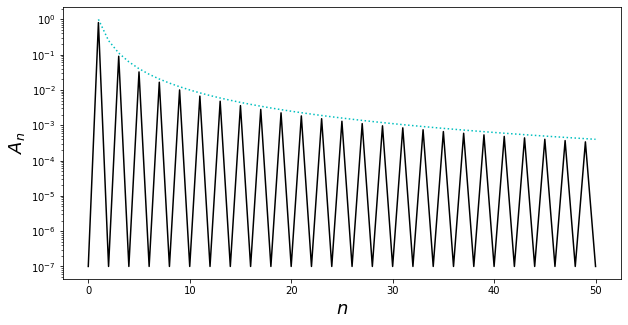

In [8]:
# First plot the A_n, just to ensure they're what we expect.
An = compute_An(50)
nn = np.arange(An.size)
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(nn,np.abs(An)+1e-7,'k-')
ax.plot(nn[1:],1./nn[1:]**2,'c:')
ax.set_yscale('log')
ax.set_xlabel(r'$n$',fontsize=18)
ax.set_ylabel(r'$A_n$',fontsize=18)

Text(0, 0.5, '$y/a$')

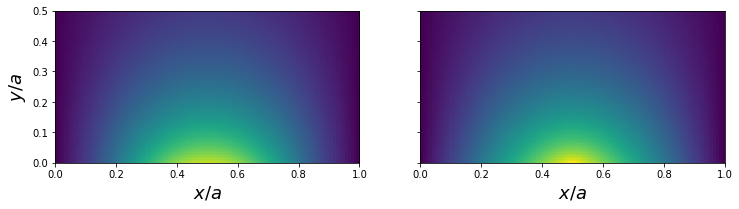

In [9]:
# Now make a figure plotting this for two values of Nmax.
Nx,Ny = 100,100
xx,yy = np.linspace(0,1,Nx),np.linspace(0,0.5,Ny)    
PhiL,PhiR = np.zeros( (Nx,Ny) ),np.zeros( (Nx,Ny) )
An  = compute_An(500)
for ix in range(Nx):
    for iy in range(Ny):
        PhiL[ix,iy] = Phi_given_An(xx[ix],yy[iy],An[:5])
        PhiR[ix,iy] = Phi_given_An(xx[ix],yy[iy],An)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(12,6))
ax[0].imshow(PhiL.T,origin='lower',extent=[xx[0],xx[-1],yy[0],yy[-1]],vmin=0,vmax=1.,aspect='equal')
ax[1].imshow(PhiR.T,origin='lower',extent=[xx[0],xx[-1],yy[0],yy[-1]],vmin=0,vmax=1.,aspect='equal')
ax[0].set_xlabel(r'$x/a$',fontsize=18)
ax[1].set_xlabel(r'$x/a$',fontsize=18)
ax[0].set_ylabel(r'$y/a$',fontsize=18)

Text(0, 0.5, '$A_n$')

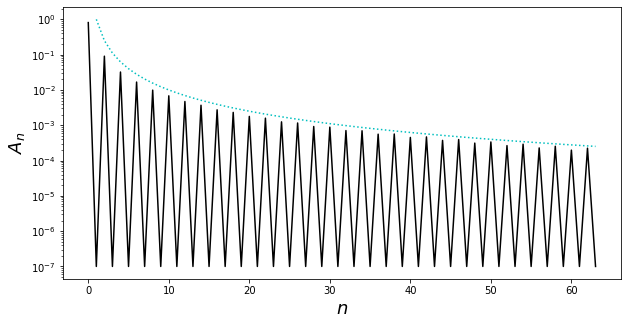

In [10]:
# For extra fun, what if we did this with a Discrete Sine Transform?
xx = np.linspace(0,1,1024)
VV = np.zeros_like(xx)
VV[xx<0.5] = 2*xx[xx<0.5]
VV[xx>0.5] = 2*(1-xx[xx>0.5])
# We don't really want to plot/play with 1024 values so trim it ...
from scipy.fftpack import dst
An = (dst(VV)/float(xx.size))[:64]
nn = np.arange(An.size)
#
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(nn,np.abs(An)+1e-7,'k-')
ax.plot(nn[1:],1./nn[1:]**2,'c:')
ax.set_yscale('log')
ax.set_xlabel(r'$n$',fontsize=18)
ax.set_ylabel(r'$A_n$',fontsize=18)